# Prediction by Diagnosis Codes
In this notebook we use some fancier networks. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import statsmodels.api as sm
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
import os, sys
import time
from datetime import datetime
%matplotlib inline

In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = ''

In [2]:
path = '/nfs/turbo/intmed-bnallamo-turbo/wsliu/Data/NRD/'

In [2]:
path = '/nfs/turbo/umms-awaljee/wsliu/Data/NRD/'

In [3]:
model_path = path + 'models/'
if not os.path.exists(model_path): os.mkdir(model_path)

In [4]:
from keras.layers import Input, Embedding, Concatenate, Reshape, Lambda, GlobalMaxPooling1D
from keras.models import Model
from keras.layers.core import Dense, Activation, Dropout, RepeatVector
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.utils import to_categorical
from keras.optimizers import Adam
from keras.initializers import Constant
import keras.backend as K

Using TensorFlow backend.


In [17]:
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from DL_utils import plot_roc
from keras_addon import AUCCheckPoint
from utils import Mat_reg
from setsum_layer import SetSum, MaskedSum, MaskedDense, MaskedPooling

In [6]:
from ccs_tools import dx_multi, pr_multi, core_dtypes_pd

## Data Preparation

In [7]:
train_df = pd.read_csv(path+'cohorts/ami/DX_train.csv', dtype=core_dtypes_pd)
tst_df = pd.read_csv(path+'cohorts/ami/DX_tst.csv', dtype=core_dtypes_pd)

In [8]:
train_df.shape

(163671, 150)

In [22]:
all_df = pd.concat([train_df, tst_df])

Define the dictionaries for DX, DX1 and hosp, from value to int. Seperating DX1:

In [7]:
DX1_cat = ['missing'] + sorted(dx_multi.ICD9CM_CODE)
DX_cat = ['missing'] + sorted(dx_multi.ICD9CM_CODE)
PR_cat = ['missing'] + sorted(pr_multi.ICD9CM_CODE)
code_cat = ['missing'] + sorted(dx_multi.ICD9CM_CODE) + sorted(dx_multi.ICD9CM_CODE) + sorted(pr_multi.ICD9CM_CODE)

n_DX_cat = len(DX_cat)
n_PR_cat = len(PR_cat)
n_code_cat = len(code_cat)

DX1_dict = dict(zip(DX1_cat, range(len(DX_cat))))
DX_dict = dict(zip(DX_cat, [0] + list(range(len(DX_cat), len(DX_cat)*2))))
PR_dict = dict(zip(PR_cat, [0] + list(range(len(DX_cat)*2-1, len(DX_cat)*2+len(PR_cat)-1))))

In [8]:
unclassified = set(dx_multi.loc[dx_multi.CCS_LVL1 == '18', 'ICD9CM_CODE'])

Not separating DX1:

In [32]:
DX_cat = ['missing'] + sorted(dx_multi.ICD9CM_CODE)
PR_cat = ['missing'] + sorted(pr_multi.ICD9CM_CODE)

n_DX_cat = len(DX_cat)
n_PR_cat = len(PR_cat)

DX_dict = dict(zip(DX_cat, range(len(DX_cat))))
PR_dict = dict(zip(PR_cat, [0] + list(range(len(DX_cat), len(DX_cat)+len(PR_cat)))))
DX1_dict = DX_dict.copy()

unclassified = set(dx_multi.loc[dx_multi.CCS_LVL1 == '18', 'ICD9CM_CODE'])

dx_ccs_cat = pd.concat([dx_multi.CCS_LVL1, dx_multi.CCS_LVL2, dx_multi.CCS_LVL3, dx_multi.CCS_LVL4]).astype('category').cat.categories
pr_ccs_cat = pd.concat([pr_multi.CCS_LVL1, pr_multi.CCS_LVL2, pr_multi.CCS_LVL3]).astype('category').cat.categories

code_cat = ['missing'] + sorted(dx_multi.ICD9CM_CODE) + sorted(pr_multi.ICD9CM_CODE) + sorted(dx_ccs_cat)[1:] + sorted(pr_ccs_cat)[1:]
n_code_cat = len(code_cat)

dx_ccs_dict = dict(zip(dx_ccs_cat[1:], range(len(dx_multi)+len(pr_multi)+1, len(dx_multi)+len(pr_multi)+len(dx_ccs_cat))))
pr_ccs_dict = dict(zip(pr_ccs_cat[1:], range(len(dx_multi)+len(pr_multi)+len(dx_ccs_cat), n_code_cat)))

In [23]:
hosp_series = all_df['HOSP_NRD'].astype('category')
hosp_cat = hosp_series.cat.categories

hosp_dict = dict(zip(hosp_cat, range(len(hosp_cat))))

## Further Predictors

### Data Formatting

In [9]:
n_DX = 29
n_PR = 15
DXs = ['DX'+str(j) for j in range(2, n_DX+2)]
PRs = ['PR'+str(j) for j in range(1, n_PR+1)]

In [27]:
trn_df, val_df = train_test_split(train_df, test_size=0.11, stratify=train_df.HOSP_NRD)
N_trn = len(trn_df)
N_val = len(val_df)
train_df = pd.concat([trn_df, val_df])

In [28]:
DX1_series = train_df['DX1'].map(DX1_dict)
DX1_array = DX1_series.values

DX1_array_trn = DX1_array[:N_trn]
DX1_array_val = DX1_array[N_trn:]

In [29]:
DX_df = train_df[DXs]

DX_df = DX_df.fillna('missing')
DX_df[DX_df.isin(['invl', 'incn'])] = 'missing'
#DX_df[DX_df.isin(rare_code)] = 'missing'
DX_df[DX_df.isin(unclassified)] = 'missing'

for dx in DXs:
    DX_df[dx] = DX_df[dx].map(DX_dict)

DX_mat = DX_df.values

DX_mat.sort(axis=1)
#DX_mat = DX_mat[:, ::-1]

DX_mat_trn = DX_mat[:N_trn, ]
DX_mat_val = DX_mat[N_trn:, ]

In [30]:
PR_df = train_df[PRs]

PR_df = PR_df.fillna('missing')
PR_df[PR_df.isin(['invl', 'incn'])] = 'missing'
#PR_df[PR_df.isin(pr_rare_code)] = 'missing'

for pr in PRs:
    PR_df[pr] = PR_df[pr].map(PR_dict)

PR_mat = PR_df.values

PR_mat.sort(axis=1)
#DX_mat = DX_mat[:, ::-1]

PR_mat_trn = PR_mat[:N_trn, ]
PR_mat_val = PR_mat[N_trn:, ]

In [31]:
hosp_series = train_df['HOSP_NRD'].map(hosp_dict)
hosp_array = hosp_series.values

hosp_array_trn = hosp_array[:N_trn]
hosp_array_val = hosp_array[N_trn:]

In [32]:
demo_mat = train_df[['AGE', 'FEMALE']].values

age_mean = train_df['AGE'].mean()
age_std = train_df['AGE'].std()

demo_mat[:, 0] = (demo_mat[:, 0]-age_mean)/age_std

In [33]:
pay1_mat = to_categorical(train_df.PAY1.values)[:, 1:]

los_array = train_df.LOS.values
los_mean = np.mean(los_array)
los_std = np.std(los_array)
los_array = (los_array - los_mean)/los_std

ed_mat = to_categorical(train_df.HCUP_ED.values)

zipinc_mat = to_categorical(train_df.ZIPINC_QRTL.values)[:, 1:]

transfer_mat = to_categorical(train_df.SAMEDAYEVENT.values)

In [34]:
other_mat = np.concatenate((demo_mat, pay1_mat, los_array.reshape(los_array.shape+(1,)), ed_mat, zipinc_mat, 
                            transfer_mat), axis=1)
other_mat_trn = other_mat[:N_trn, ]
other_mat_val = other_mat[N_trn:, ]

In [35]:
y = train_df['readm30'].values.astype(int)

Y_trn = to_categorical(y[:N_trn])
Y_val = to_categorical(y[N_trn:])

## Model Building

In [8]:
from setsum_layer import SetSum, MaskedSum, MaskedDense

In [9]:
code_embed_dim = 100
hosp_embed_dim = 1

In [43]:
embed_glove = np.load(path+'all/embed_mat_pen0824.npy')

In [228]:
embed_glove = np.load(path+'all/embed_mat0816.npy')

In [229]:
embed_glove = np.concatenate((embed_glove[:n_DX_cat, :], embed_glove[1:, :]), axis=0)

In [23]:
embed_glove.shape

(20153, 100)

In [24]:
n_code_cat

20153

In [44]:
fc_width = 64
md_width = 128

In [62]:
input_DX1 = Input(shape=(1,))
DX1_embed = Embedding(input_dim=n_code_cat, output_dim=code_embed_dim, embeddings_initializer=Constant(embed_glove), 
                     name='DX1_embed')(input_DX1)
DX1_embed = Reshape((code_embed_dim,))(DX1_embed)

input_DX = Input(shape = (n_DX,))
DX_embed = Embedding(input_dim=n_code_cat, output_dim=code_embed_dim, mask_zero=True, embeddings_initializer=Constant(embed_glove), 
                     name='DX_embed')(input_DX)

DX_feature = MaskedDense(md_width, activation='relu')(DX_embed)
#DX_feature = MaskedDense(DX_embed_dim, activation='relu')(DX_feature)
DX_feature = MaskedSum()(DX_feature)

input_PR = Input(shape = (n_PR,))
PR_embed = Embedding(input_dim=n_code_cat, output_dim=code_embed_dim, mask_zero=True, embeddings_initializer=Constant(embed_glove),
                     name='PR_embed')(input_PR)

PR_feature = MaskedDense(md_width, activation='relu')(PR_embed)
PR_feature = MaskedSum()(PR_feature)

input_hosp = Input(shape=(1,))
hosp_embed = Embedding(input_dim=len(hosp_cat), output_dim=hosp_embed_dim, input_length=1)(input_hosp)
hosp_embed = Reshape((hosp_embed_dim, ))(hosp_embed)

input_other = Input(shape=(other_mat.shape[1], ))

merged = Concatenate(axis=1)([DX1_embed, DX_feature, PR_feature, hosp_embed, input_other])

x = Dense(fc_width, activation='relu')(merged)
#x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)

prediction = Dense(2, activation='softmax')(x)
model = Model(inputs=[input_DX1, input_DX, input_PR, input_hosp, input_other], outputs=prediction)

In [46]:
for l in model.layers:
    if l.name=='DX_embed' or l.name=='PR_embed' or l.name=='DX1_embed':
        l.trainable = False

In [47]:
adam = Adam(lr=0.0002)
model.compile(optimizer=adam, loss='categorical_crossentropy')

In [64]:
adam = Adam(lr=0.00001)
model.compile(optimizer=adam, loss='categorical_crossentropy')

In [65]:
checkpoint = ModelCheckpoint(filepath=model_path+'ami_glove_valloss1.h5', save_best_only=True, save_weights_only=True)
auccheckpoint = AUCCheckPoint(filepath=model_path+'ami_glove_auc1.h5', validation_y=Y_val[:, 1], 
                             validation_x=[DX1_array_val, DX_mat_val, PR_mat_val, hosp_array_val, other_mat_val])
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=K.epsilon())
earlystop = EarlyStopping(monitor='val_loss', patience=30)

In [49]:
class_weight = {0:(Y_trn.shape[0]/sum(Y_trn[:, 0])), 1:(Y_trn.shape[0]/sum(Y_trn[:, 1]))}

In [66]:
hist = model.fit([DX1_array_trn, DX_mat_trn, PR_mat_trn, hosp_array_trn, other_mat_trn], Y_trn, 
                 batch_size=128, epochs=10, callbacks=[checkpoint, auccheckpoint, reduce_lr, earlystop], class_weight=class_weight, 
                 validation_data=[[DX1_array_val, DX_mat_val, PR_mat_val, hosp_array_val, other_mat_val], Y_val], 
                verbose=1)

Train on 145667 samples, validate on 18004 samples
Epoch 1/10
145667/145667 [==============================] - 7s 51us/step - loss: 1.2249 - val_loss: 0.6124
AUC: 0.7180

Epoch 2/10
145667/145667 [==============================] - 7s 47us/step - loss: 1.2225 - val_loss: 0.6021
AUC: 0.7181

Epoch 3/10
145667/145667 [==============================] - 7s 47us/step - loss: 1.2219 - val_loss: 0.6027
AUC: 0.7182

Epoch 4/10
145667/145667 [==============================] - 7s 47us/step - loss: 1.2209 - val_loss: 0.6102
AUC: 0.7182

Epoch 5/10
145667/145667 [==============================] - 7s 48us/step - loss: 1.2185 - val_loss: 0.6195
AUC: 0.7182

Epoch 6/10
145667/145667 [==============================] - 7s 48us/step - loss: 1.2189 - val_loss: 0.6132
AUC: 0.7183

Epoch 7/10
145667/145667 [==============================] - 7s 47us/step - loss: 1.2173 - val_loss: 0.6073
AUC: 0.7182

Epoch 8/10
145667/145667 [==============================] - 7s 47us/step - loss: 1.2163 - val_loss: 0.6154
AU

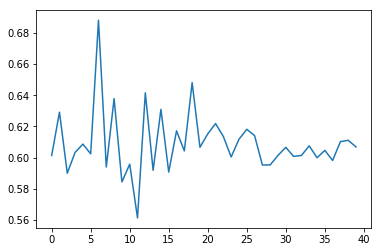

In [52]:
plt.plot(hist.history['val_loss'])

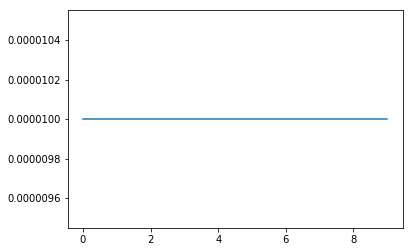

In [67]:
plt.plot(hist.history['lr'])

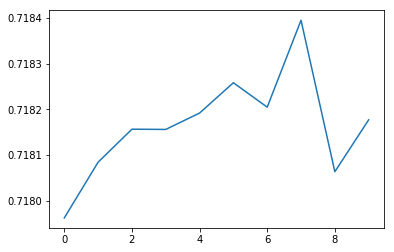

In [68]:
plt.plot(auccheckpoint.auc_history)

In [55]:
DX1_array_tst = tst_df.DX1.map(DX_dict).values

In [56]:
DX_df_tst = tst_df[DXs]
DX_df_tst = DX_df_tst.fillna('missing')
DX_df_tst[DX_df_tst.isin(['invl', 'incn'])]
#DX_df_tst[DX_df_tst.isin(rare_code)] = 'missing'
DX_df_tst[DX_df_tst.isin(unclassified)] = 'missing'

for dx in DXs:
    DX_df_tst[dx] = DX_df_tst[dx].map(DX_dict)

DX_mat_tst = DX_df_tst.values

DX_mat_tst.sort(axis=1)
#DX_mat_tst = DX_mat_tst[:, ::-1]

In [57]:
PR_df_tst = tst_df[PRs]
PR_df_tst = PR_df_tst.fillna('missing')
PR_df_tst[PR_df_tst.isin(['invl', 'incn'])] = 'missing'
#PR_df_tst[PR_df_tst.isin(pr_rare_code)] = 'missing'

for pr in PRs:
    PR_df_tst[pr] = PR_df_tst[pr].map(PR_dict)

PR_mat_tst = PR_df_tst.values
PR_mat_tst.sort(axis=1)

In [58]:
demo_mat_tst = tst_df[['AGE', 'FEMALE']].values
demo_mat_tst[:, 0] = (demo_mat_tst[:, 0]-age_mean)/age_std

hosp_array_tst = tst_df['HOSP_NRD'].map(hosp_dict).values

pay1_mat_tst = to_categorical(tst_df.PAY1.values)[:, 1:]

los_array_tst = (tst_df.LOS.values - los_mean)/los_std

ed_mat_tst = to_categorical(tst_df.HCUP_ED.values)

zipinc_mat_tst = to_categorical(tst_df.ZIPINC_QRTL.values)[:, 1:]

transfer_mat_tst = to_categorical(tst_df.SAMEDAYEVENT.values)

other_mat_tst = np.concatenate((demo_mat_tst, pay1_mat_tst, los_array_tst.reshape(los_array_tst.shape+(1,)), 
                                ed_mat_tst, zipinc_mat_tst, transfer_mat_tst), axis=1)

In [69]:
model.load_weights(model_path+'ami_glove_auc1.h5')

In [70]:
y = model.predict([DX1_array_tst, DX_mat_tst, PR_mat_tst, hosp_array_tst, other_mat_tst], verbose=1)

y_pred = y[:, 1]
y_true = tst_df.readm30.astype(int).values

18186/18186 [==============================] - 1s 34us/step


{0: 0.7144448385484797}

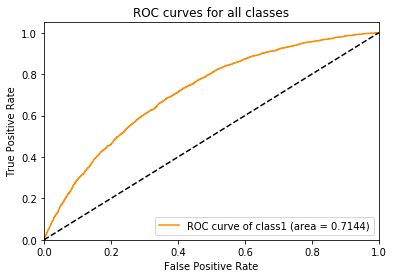

In [71]:
plot_roc(y_pred, y_true)

## Model Average

In [7]:
from sklearn.metrics import roc_curve, auc

In [8]:
y_pred_lst = []
n_fold = 10
for fold_ind in range(n_fold):
    y_pred_lst.append(np.load('output/y_pred'+str(fold_ind)+'.npy'))

In [10]:
y_true = tst_df.readm30.astype(int).values

In [11]:
auc_lst = []

for y_pred in y_pred_lst:
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)
    auc_lst.append(roc_auc)

In [12]:
np.mean(auc_lst), np.max(auc_lst), np.min(auc_lst)

(0.712201901320557, 0.7147529128986604, 0.70995568503486)

In [13]:
y_pred_mat = np.column_stack(y_pred_lst)

In [14]:
y_pred_avg = y_pred_mat.mean(axis=1)

{0: 0.7154705749444924}

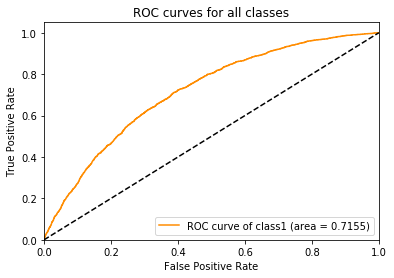

In [15]:
plot_roc(y_pred_avg, y_true)

In [16]:
np.save('output/y_pred_ami_sepdx1_10.npy', y_pred_mat)

## Separate Hospital Embeddings

In [11]:
cohort = 'ami'
tst_seed = 0

In [25]:
all_df = pd.read_csv(path+'cohorts30/{}/pred_comorb.csv'.format(cohort), dtype=core_dtypes_pd)
tst_key = pd.read_csv(path+'cohorts30/{}/tst_key{}.csv'.format(cohort, tst_seed), names = ['KEY_NRD'])
tst_df = all_df.loc[all_df.KEY_NRD.isin(tst_key.KEY_NRD)]
train_df0 = all_df.loc[~all_df.KEY_NRD.isin(tst_key.KEY_NRD)].reset_index()

In [13]:
DX_cat = ['missing'] + sorted(dx_multi.ICD9CM_CODE)
PR_cat = ['missing'] + sorted(pr_multi.ICD9CM_CODE)
n_DX_cat = len(DX_cat)
n_PR_cat = len(PR_cat)
unclassified = set(dx_multi.loc[dx_multi.CCS_LVL1 == '18', 'ICD9CM_CODE'])
dx_ccs_cat = pd.concat([dx_multi.CCS_LVL1, dx_multi.CCS_LVL2, dx_multi.CCS_LVL3, dx_multi.CCS_LVL4]).astype('category').cat.categories
pr_ccs_cat = pd.concat([pr_multi.CCS_LVL1, pr_multi.CCS_LVL2, pr_multi.CCS_LVL3]).astype('category').cat.categories
DX1_dict = dict(zip(DX_cat, range(len(DX_cat))))
DX_dict = dict(zip(DX_cat, [0] + list(range(len(DX_cat), len(DX_cat)*2))))
PR_dict = dict(zip(PR_cat, [0] + list(range(len(DX_cat)*2-1, len(DX_cat)*2+len(PR_cat)-1))))
code_cat = ['missing']+sorted(dx_multi.ICD9CM_CODE)*2+sorted(pr_multi.ICD9CM_CODE)+sorted(dx_ccs_cat)[1:]*2+sorted(pr_ccs_cat)[1:]
n_code_cat = len(code_cat)    
dx1_ccs_dict = dict(zip(dx_ccs_cat[1:], range(1+len(dx_multi)*2+len(pr_multi), len(dx_multi)*2+len(pr_multi)+len(dx_ccs_cat))))
dx_ccs_dict = dict(zip(dx_ccs_cat[1:], range(1+len(dx_multi)*2+len(pr_multi)+len(dx_ccs_cat[1:]), 
                                                 1+len(dx_multi)*2+len(pr_multi)+len(dx_ccs_cat[1:])*2)))
pr_ccs_dict = dict(zip(pr_ccs_cat[1:], range(1+len(dx_multi)*2+len(pr_multi)+len(dx_ccs_cat[1:])*2, n_code_cat)))
hosp_series = all_df['HOSP_NRD'].astype('category')
hosp_cat = hosp_series.cat.categories
hosp_dict = dict(zip(hosp_cat, range(len(hosp_cat))))

n_DX = 29
n_PR = 15
DXs = ['DX'+str(j) for j in range(2, n_DX+2)]
PRs = ['PR'+str(j) for j in range(1, n_PR+1)]

In [26]:
age_mean = train_df0['AGE'].mean()
age_std = train_df0['AGE'].std()
los_mean = train_df0['LOS'].mean()
los_std = train_df0['LOS'].std()
n_pay1 = int(train_df0['PAY1'].max())+1
n_ed = int(train_df0['HCUP_ED'].max())+1
n_zipinc = int(train_df0['ZIPINC_QRTL'].max())+1
demo_mat_tst = tst_df[['AGE', 'FEMALE']].values
demo_mat_tst[:, 0] = (demo_mat_tst[:, 0]-age_mean)/age_std
hosp_array_tst = tst_df['HOSP_NRD'].map(hosp_dict).values
pay1_mat_tst = to_categorical(tst_df.PAY1.values, num_classes=n_pay1)[:, 1:]
los_array_tst = (tst_df.LOS.values - los_mean)/los_std
ed_mat_tst = to_categorical(tst_df.HCUP_ED.values, num_classes=n_ed)
zipinc_mat_tst = to_categorical(tst_df.ZIPINC_QRTL.values, num_classes=n_zipinc)[:, 1:]
#transfer_mat_tst = to_categorical(tst_df.SAMEDAYEVENT.values)
other_mat_tst = np.concatenate((demo_mat_tst, pay1_mat_tst, los_array_tst.reshape(los_array_tst.shape+(1,)), 
                                ed_mat_tst, zipinc_mat_tst), axis=1)

In [21]:
code_embed_dim = 200
embed_initializer = 'uniform'
fc_width = 512
md_width = 128
lr1 = 2e-4
lr2 = 2e-5
dropout = 0
batchsize = 256
penalty = 0.
hosp_embed_dim = 1

In [27]:
input_DX1 = Input(shape=(1,))
DX1_embed = Embedding(input_dim=n_code_cat, output_dim=code_embed_dim, embeddings_initializer=embed_initializer, 
                             name='DX1_embed')(input_DX1)
DX1_embed = Reshape((code_embed_dim,))(DX1_embed)
input_DX = Input(shape = (n_DX,))
DX_embed = Embedding(input_dim=n_code_cat, output_dim=code_embed_dim, mask_zero=True, embeddings_initializer=embed_initializer, 
                             name='DX_embed')(input_DX)
DX_embed = MaskedDense(md_width, activation='relu')(DX_embed)
DX_embed = MaskedSum()(DX_embed)
input_PR = Input(shape = (n_PR,))
PR_embed = Embedding(input_dim=n_code_cat, output_dim=code_embed_dim, mask_zero=True, embeddings_initializer=embed_initializer,
                             name='PR_embed')(input_PR)
PR_embed = MaskedDense(md_width, activation='relu')(PR_embed)
PR_embed = MaskedSum()(PR_embed)
input_hosp = Input(shape=(1,))
hosp_embed = Embedding(input_dim=len(hosp_cat), output_dim=hosp_embed_dim, input_length=1)(input_hosp)
hosp_embed = Reshape((hosp_embed_dim, ))(hosp_embed)
input_other = Input(shape=(other_mat_tst.shape[1], ))
merged = Concatenate(axis=1)([DX1_embed, DX_embed, PR_embed, input_other])
x = Dense(fc_width, activation='relu')(merged)
x = Dropout(dropout)(x)
x = Concatenate(axis=1)([x, hosp_embed])
prediction = Dense(1, activation='sigmoid', name='prediction', use_bias=False)(x)
model = Model(inputs=[input_DX1, input_DX, input_PR, input_hosp, input_other], outputs=prediction)

In [28]:
model.load_weights(model_path+'best30_hosp_ami0_0.h5')

In [30]:
hosp_embed_layer = model.layers[15]

In [32]:
hosp_embed_mat = hosp_embed_layer.get_weights()[0]

In [43]:
hosp_embed_mat.std()

0.044123374

In [41]:
hosp_embed_mat = hosp_embed_mat*(model.layers[-1].get_weights()[0][-1, 0])

In [66]:
hosp_embed_mats = []
last_weights = []
tst_seed = 1
for val_seed in range(9):
    model.load_weights(model_path+'best30_hosp_{}{}_{}.h5'.format(cohort, tst_seed, val_seed))
    hosp_embed_layer = model.layers[15]
    hosp_embed_mat = (hosp_embed_layer.get_weights()[0])*(model.layers[-1].get_weights()[0][-1, 0])
    hosp_embed_mats.append(hosp_embed_mat)
    last_weights.append((model.layers[-1].get_weights()[0][-1, 0]))

In [67]:
for hosp_embed_mat in hosp_embed_mats:
    hosp_embed_mat = (hosp_embed_mat - hosp_embed_mat.mean())/(hosp_embed_mat.std())

In [68]:
hosp_embed_mats = np.column_stack(hosp_embed_mats)

In [69]:
hosp_embed_avg1 = hosp_embed_mats.mean(axis=1)

In [65]:
hosp_embed_avg0.shape

(874,)

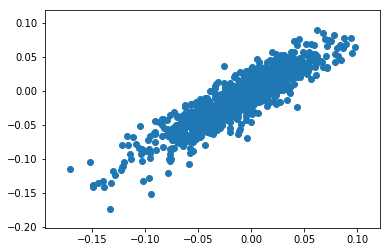

In [70]:
plt.scatter(hosp_embed_avg0, hosp_embed_avg1)